In [ ]:
# power = 260mW 
# T = 64 C 
# %matplotlib ipympl 
%matplotlib qt 
%load_ext autoreload 
%autoreload 2
from pianoq.lab.asi_cam import ASICam
from pianoq.lab.dmd import DMD
import numpy as np 
from pianoq.misc.mplt import mimshow, mplot
import datetime 
import time 
from pianoq.lab.photon_scan import PhotonScanner
from pianoq.lab.time_tagger import QPTimeTagger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
cam = ASICam()

In [34]:
cam.close()

In [56]:
path = r'G:\My Drive\Projects\DMD\quantum\Results\Callibrations'
# cam.set_roi(4300, 2100, 500, 500)
cam.set_exposure(3)
cam.set_roi(None, None, None, None)
cam.set_binning(4)
# cam.show_image(vmin=None, vmax=None)
cam.save_image(rf'{path}\farfield_plane_yes_lens_75mm_f1_200mm.fits')

In [23]:
dmd = DMD()

Connected!
Built project!


In [26]:
dmd.set_white()

In [15]:
dmd.shape

(1140, 912)

In [ ]:
# pump with f=75mm 
mask = np.ones(dmd.shape, dtype=np.uint8)
mask[:200, :] = 0 
mask[700:, :] = 0 
mask[:, :350] = 0 
mask[:, 600:] = 0 
dmd.set_image(mask)

In [38]:
mask = np.ones(dmd.shape, dtype=np.uint8)
# mask[:200, :] = 0 
# mask[700:, :] = 0 
# mask[:, :350] = 0 
# mask[:, 600:] = 0 
dmd.set_image(mask)

In [54]:
# dmd.set_grating(30, phase=3)
mask = dmd.get_grating(150, 0)
# mimshow(mask)
dmd.set_image(mask)

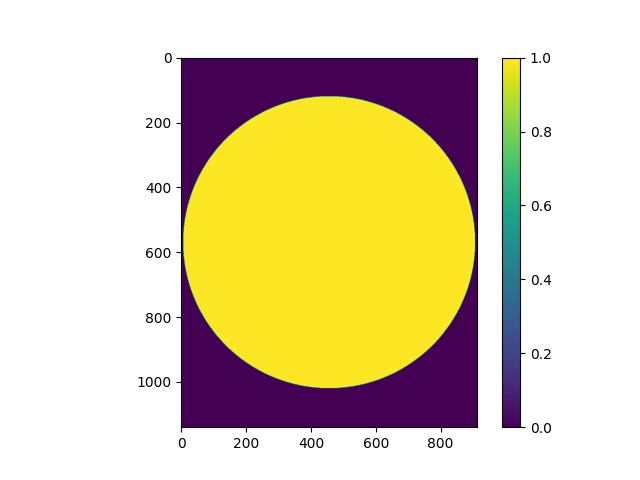

(<Figure size 640x480 with 2 Axes>, <Axes: >)

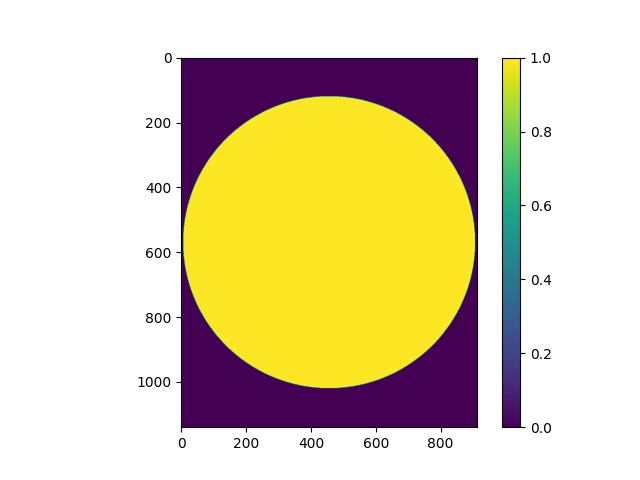

In [ ]:
r = 450
X0 = 0
Y0 = 0
mask = np.zeros(dmd.shape, dtype=np.uint8)
mask[np.sqrt((dmd.XX-X0)**2+(dmd.YY-Y0)**2) < r] = 1 
dmd.set_image(mask)
# mimshow(mask)

In [25]:
dmd.set_black()

In [12]:
dmd.set_grating(500)

In [17]:
dmd.close()

In [69]:
from pianoq.lab.lee_holo.generate_lee import main, make_oam_donut, orthogonal_lee
GRATING_PERIOD_PX = 25            # p (pixels)  ⇒ ν = 1/p cycles/pixel
CARRIER_F         = (1/GRATING_PERIOD_PX, 0)  # along +x by default

target = make_oam_donut(Nx=dmd.Nx, Ny=dmd.Ny, ell=2, r0=0.25)
# target = make_oam_donut(Nx=dmd.Nx, Ny=dmd.Ny, ell=0, r0=0.0, sigma=0.2)
hologram, _ = orthogonal_lee(target, carrier_f=CARRIER_F, duty_cycle=0.5)
dmd.set_image(hologram.astype(bool))
# mimshow(hologram)

In [52]:
from pianoq.lab.photon_counter import PhotonCounter
from pianoq.lab.thorlabs_motor import ThorlabsKcubeDC, ThorlabsKcubeStepper
from pianoq.lab.time_tagger import QPTimeTagger

integration_time = 5 
# coin_window = 4e-9 
# ph = PhotonCounter(serial_port='COM8', integration_time=integration_time)
coin_window = 1e-9 
tt = ph = QPTimeTagger(integration_time=integration_time, coin_window=coin_window, single_channel_delays=(0, 5000))

In [ ]:
timeout = 100000
x_motor = ThorlabsKcubeDC(serial_number=27253522, timeout=timeout)
y_motor = ThorlabsKcubeStepper(serial_number=26001271, timeout=timeout)

In [54]:
tt = ph = QPTimeTagger(integration_time=integration_time, coin_window=coin_window, single_channel_delays=(0, 5000))  # When DMD-plane fiber is 100um 1m.
# tt = ph = QPTimeTagger(integration_time=integration_time, coin_window=coin_window, single_channel_delays=(0, 500))  # When both are 50um 2m fibers 
# tt.close()

In [18]:
x_motor.close()
y_motor.close()
ph.close()

In [63]:
s1, s2, c = ph.read_interesting()
s1, s2, c = s1.item(), s2.item(), c.item()
acc = 2*s1*s2*coin_window
real_c = c - acc 
std = np.sqrt(c) / np.sqrt(ph.integration_time)
print(f'{c=:.1f}; {real_c=:.1f}+-{std:.1f}')
print(x_motor.get_position())
print(y_motor.get_position())

c=86.2; real_c=32.3+-4.2
16.4
11.7500006


In [57]:
tt.read_interesting()

[np.float64(313536.8), np.float64(106961.6), np.float64(83.60000000000001)]

In [53]:
start_x = 16.0 # 16.5
start_y = 11.5 # 14.75  
x_pixels = 20
y_pixels = 20
pixel_size_x = 0.1
pixel_size_y = 0.1
name = 'checker_70_timetagger_z_12_fiber_100um'

timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
dir_path = r'G:\My Drive\Projects\DMD\quantum\Results\Scans'

path = f'{dir_path}\\{timestamp}_{name}.scan'
scanner = PhotonScanner(integration_time, start_x, start_y, x_pixels, y_pixels, pixel_size_x, pixel_size_y,
                        run_name=name, is_timetagger=False, coin_window=coin_window, saveto_path=path)

In [41]:
mimshow(dmd.get_grating(50))
dmd.set_grating(50)

In [45]:
dmd.set_checkerboard(70)
mimshow(dmd.get_checkerboard(70))
# mimshow(dmd.get_grating(40))

(<Figure size 640x480 with 2 Axes>, <Axes: >)

In [37]:
assert isinstance(ph, (PhotonCounter, QPTimeTagger))

In [54]:
time.sleep(10)
single1s, single2s, coincidences = scanner.scan(x_motor=x_motor, y_motor=y_motor, ph=ph)

Moving to starting position...
starting scan
dur: 0. pix: 0, 0. Singles1: 256362. Singles2: 101829. Coincidence: 74.60. real_coin: 22.4.
dur: 6. pix: 0, 1. Singles1: 256934. Singles2: 103350. Coincidence: 76.60. real_coin: 23.5.
dur: 12. pix: 0, 2. Singles1: 256227. Singles2: 101436. Coincidence: 68.60. real_coin: 16.6.
dur: 18. pix: 0, 3. Singles1: 255797. Singles2: 105980. Coincidence: 66.60. real_coin: 12.4.
dur: 24. pix: 0, 4. Singles1: 256283. Singles2: 104323. Coincidence: 67.00. real_coin: 13.5.
dur: 30. pix: 0, 5. Singles1: 256072. Singles2: 104250. Coincidence: 66.80. real_coin: 13.4.
dur: 36. pix: 0, 6. Singles1: 256819. Singles2: 105580. Coincidence: 55.80. real_coin: 1.6.
dur: 42. pix: 0, 7. Singles1: 257203. Singles2: 101146. Coincidence: 56.80. real_coin: 4.8.
dur: 47. pix: 0, 8. Singles1: 256421. Singles2: 101955. Coincidence: 57.00. real_coin: 4.7.
dur: 53. pix: 0, 9. Singles1: 256509. Singles2: 101642. Coincidence: 58.60. real_coin: 6.5.
nan issue in timetagger
dur: 59

In [ ]:
fig, ax = mplot(scanner.result.real_coins[0, :])
ax.plot(scanner.result.real_coins[1, :])

In [51]:
# x_motor.move_absolute(16.6)
x_motor.move_absolute(17.2)

In [72]:
tt.close()

In [ ]:
tt = ph = QPTimeTagger(integration_time=1, coin_window=0.8e-9, single_channel_delays=(0, 5000))  # When DMD-plane fiber is 100um 1m.


In [22]:
tt.set_integration_time(0.5)
# tt.coin_window
tt.show_gui(60)

nan issue in timetagger
